In [14]:
%load_ext autoreload
%autoreload 2

import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import camb

import bornraytrace.lensing as lensing

import glass.shells

from forward_model import preprocessing_gower_street, forward, weight_map_w_redshift, kappa2shear
from ray_trace import ray_trace, intrinsic_alignments
from utils import downgrade_mask

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
path_info = '/n17data/sguerrini/GowerStreetSims/PKDGRAV3_on_DiRAC_DES_330 - Sheet1.csv'
path_sims = '/n17data/sguerrini/GowerStreetSims/'
sim_number = 1
nside = 512

In [3]:
overdensity_array, z_bin_edges, cosmo_params = preprocessing_gower_street(path_sims, path_info, sim_number, nside=nside, verbose=True)

[!] Preprocessing the Gower Street simulation 1...
[!] Reading the cosmological parameters...
[!] Done in 2.64 min.
[!] Extracting overdensity maps and redshift edges for the Gower Street simulation 1...


100it [02:55,  1.75s/it]


[!] Done in 2.93 min.
[!] Number of redshift shells: 77
[!] Larger redshift: 2.07237


In [4]:
overdensity_array.shape

(77, 3145728)

In [5]:
z_bin_edges.shape

(78,)

In [6]:
cosmo_params

{'h': array([0.66736206]),
 'Omega_m': array([0.29004048]),
 'Omega_b': array([0.05021784]),
 'sigma_8': array([0.7657514]),
 'n_s': array([0.94965154]),
 'w': array([-1.00894147]),
 'm_nu': array([0.06]),
 'A_s': array([2.20263889e-09])}

In [7]:
mean_density = np.mean(overdensity_array[z_bin_edges[1:]<0.15], axis=0)

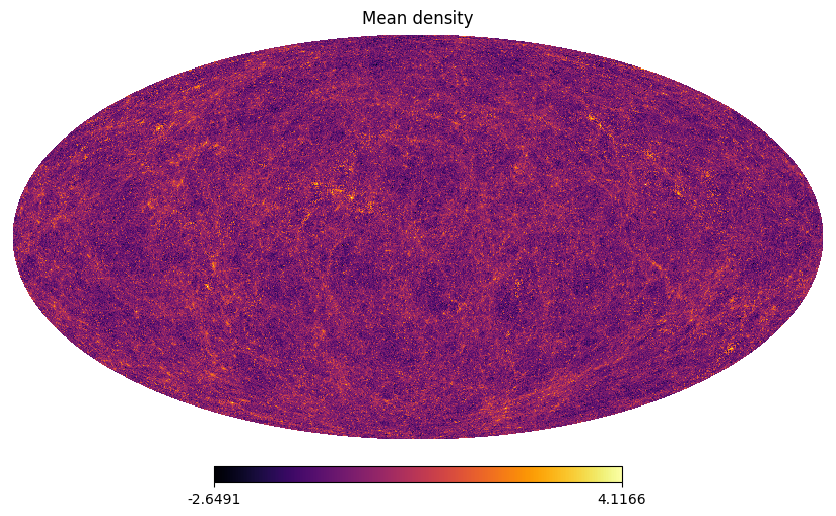

In [8]:
hp.mollview(np.log(mean_density+1), title='Mean density', cmap='inferno')
plt.show()

In [9]:
kappa_lensing = ray_trace(overdensity_array, z_bin_edges, cosmo_params, method='glass', verbose=True)
kappa_lensing_brt = ray_trace(overdensity_array, z_bin_edges, cosmo_params, method='bornraytrace', verbose=True)

[!] Performing the ray tracing using GLASS...


100%|██████████| 77/77 [00:01<00:00, 44.70it/s]


[!] Performing the ray tracing using BornRaytrace...


100%|██████████| 77/77 [00:33<00:00,  2.28it/s]


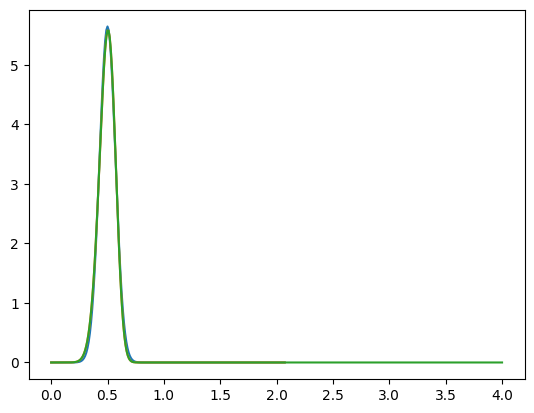

In [10]:
z = np.linspace(z_bin_edges[0], z_bin_edges[-1], 200)
dndz = np.exp(-(z-0.5)**2/0.1**2)
dndz /= np.trapz(dndz, z)

z_mode = 0.4390
alpha = 10
beta = 4.988
dndz_smail = (z/z_mode)**(alpha)*np.exp(-(z/z_mode)**beta)
dndz_smail /= np.trapz(dndz_smail, z)

path = '/home/guerrini/cosmosis-standard-library/ia_pred/nz_source/'

z_SIS = np.loadtxt(path+'z.txt')
dndz_SIS = np.loadtxt(path+'bin_1.txt')

plt.figure()

plt.plot(z, dndz)
plt.plot(z, dndz_smail)
plt.plot(z_SIS, dndz_SIS)
plt.show()

In [11]:
kappa_bar = np.zeros_like(kappa_lensing[0])
kappa_bar_brt = np.zeros_like(kappa_lensing[0])

weights = glass.shells.tophat_windows(z_bin_edges)

for i in range(len(z_bin_edges)-1):
    z_i, dndz_i = glass.shells.restrict(z, dndz, weights[i])

    ngal = np.trapz(dndz_i, z_i)
    kappa_bar += ngal * kappa_lensing[i]
    kappa_bar_brt += ngal * kappa_lensing_brt[i]

kappa_bar /= np.trapz(dndz, z)
kappa_bar_brt /= np.trapz(dndz, z)

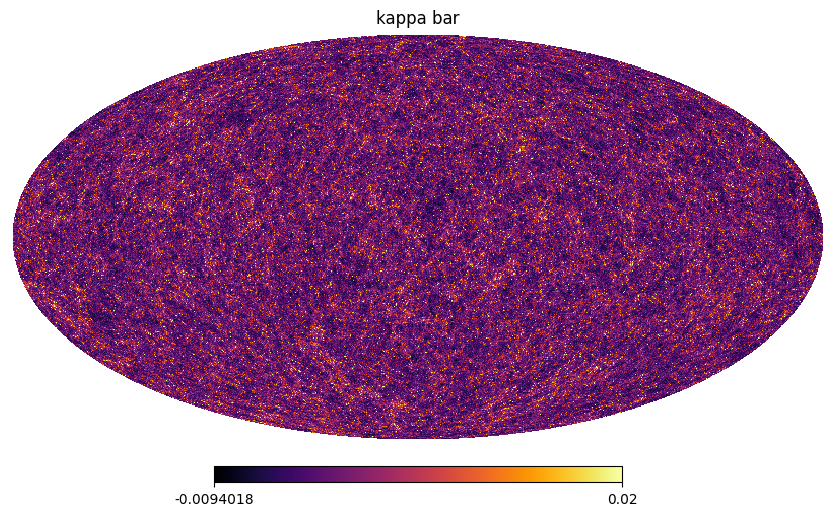

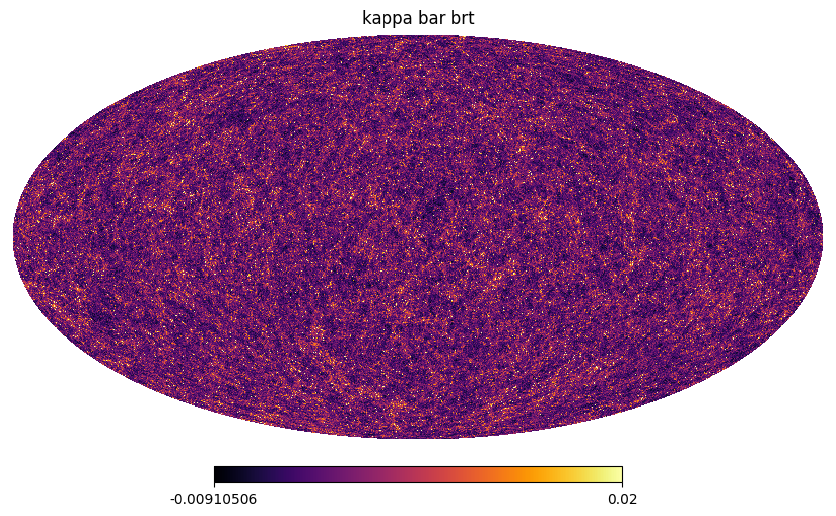

In [12]:
hp.mollview(kappa_bar, title='kappa bar', cmap='inferno', max=0.02)
plt.show()

hp.mollview(kappa_bar_brt, title='kappa bar brt', cmap='inferno', max=0.02)
plt.show()

In [13]:
#Comparison with the power spectrum

#Load parameters for the cosmology
h = cosmo_params["h"]
Om = cosmo_params["Omega_m"]
Ob = cosmo_params["Omega_b"]
Oc = Om - Ob
ns = cosmo_params["n_s"]
m_nu = cosmo_params["m_nu"]
w = cosmo_params["w"]
As = cosmo_params["A_s"]

nside=512
lmax = 2*nside

pars = camb.set_params(H0=100*h, omch2=Oc*h**2, ombh2=Ob*h**2, ns=ns, mnu=m_nu, w=w, As=As, WantTransfer=True, NonLinear=camb.model.NonLinear_both)

#get the angular power spectra of the lensing map
sim_cls = hp.anafast(kappa_bar, pol=True, lmax=lmax, use_pixel_weights=True)
sim_cls_brt = hp.anafast(kappa_bar_brt, pol=True, lmax=lmax, use_pixel_weights=True)

#getthe expected cl's from CAMB
pars.min_l = 1
pars.set_for_lmax(lmax)
pars.SourceWindows = [
    camb.sources.SplinedSourceWindow(z=z, W=dndz, source_type='lensing')
]
theory_cls = camb.get_results(pars).get_source_cls_dict(lmax=lmax, raw_cl=True)

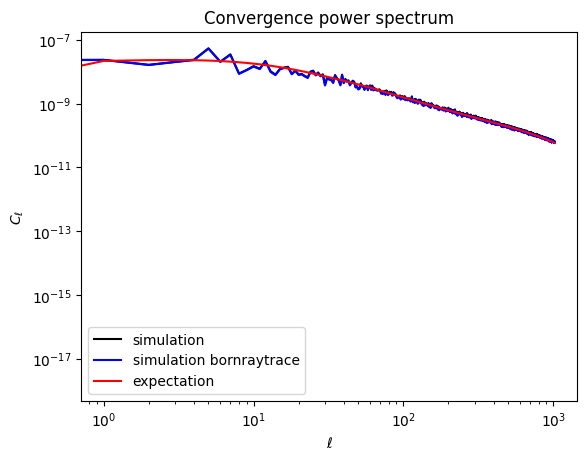

/tmp/ipykernel_181168/2400483270.py:24: RuntimeWarning: divide by zero encountered in divide
  plt.plot(l, sim_cls/(theory_cls['W1xW1']*pw**2))
/tmp/ipykernel_181168/2400483270.py:25: RuntimeWarning: divide by zero encountered in divide
  plt.plot(l, sim_cls_brt/(theory_cls['W1xW1']*pw**2))


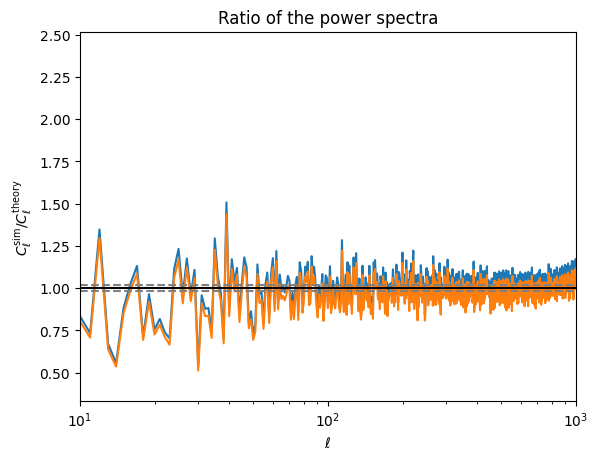

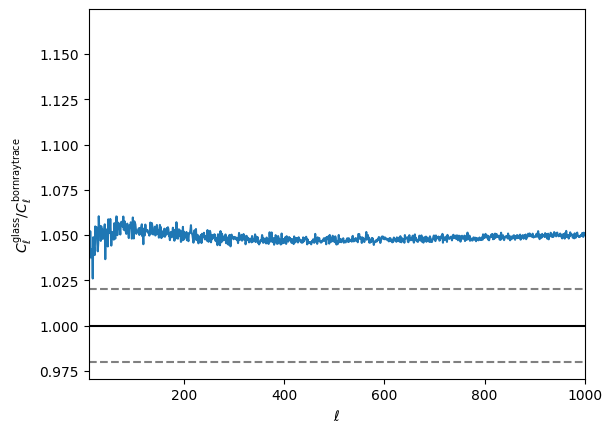

In [14]:
plt.figure()

#get the HEALPix pixel window function since the lensing fields have it
pw = hp.pixwin(nside, lmax=lmax)

l = np.arange(lmax+1)
plt.plot(l, sim_cls, label="simulation", c='k')
plt.plot(l, sim_cls_brt, label="simulation bornraytrace", c='b')
plt.plot(l, theory_cls['W1xW1']*pw**2, label="expectation", c='r')

plt.xscale('log')
plt.yscale('log')

plt.legend()

plt.xlabel(r"$\ell$")
plt.ylabel(r"$C_\ell$")
plt.title("Convergence power spectrum")

plt.show()

plt.figure()

plt.plot(l, sim_cls/(theory_cls['W1xW1']*pw**2))
plt.plot(l, sim_cls_brt/(theory_cls['W1xW1']*pw**2))
plt.axhline(1, c='k')
plt.axhline(1.02, c='gray', ls='--')
plt.axhline(0.98, c='gray', ls='--')

plt.xlabel(r"$\ell$")
plt.ylabel(r"$C_\ell^{\rm sim}/C_\ell^{\rm theory}$")
plt.title("Ratio of the power spectra")

plt.xlim(10, 1e3)

plt.xscale('log')

plt.show()

plt.figure()

plt.plot(l, sim_cls/sim_cls_brt)
plt.axhline(1, c='k')
plt.axhline(1.02, c='gray', ls='--')
plt.axhline(0.98, c='gray', ls='--')

plt.xlabel(r"$\ell$")
plt.ylabel(r"$C_\ell^{\rm glass}/C_\ell^{\rm bornraytrace}$")

plt.xlim(10, 1e3)

plt.show()

In [15]:
A_ia = 0.49
eta_ia = 0.

kappa_ia = intrinsic_alignments(overdensity_array, z_bin_edges, cosmo_params, A_ia=A_ia, eta_ia=eta_ia)

In [16]:
kappa_ia_bar = np.zeros_like(kappa_lensing[0])

weights = glass.shells.tophat_windows(z_bin_edges)

for i in range(len(z_bin_edges)-1):
    z_i, dndz_i = glass.shells.restrict(z, dndz, weights[i])

    ngal = np.trapz(dndz_i, z_i)
    kappa_ia_bar += ngal * kappa_ia[i]

kappa_ia_bar /= np.trapz(dndz, z)

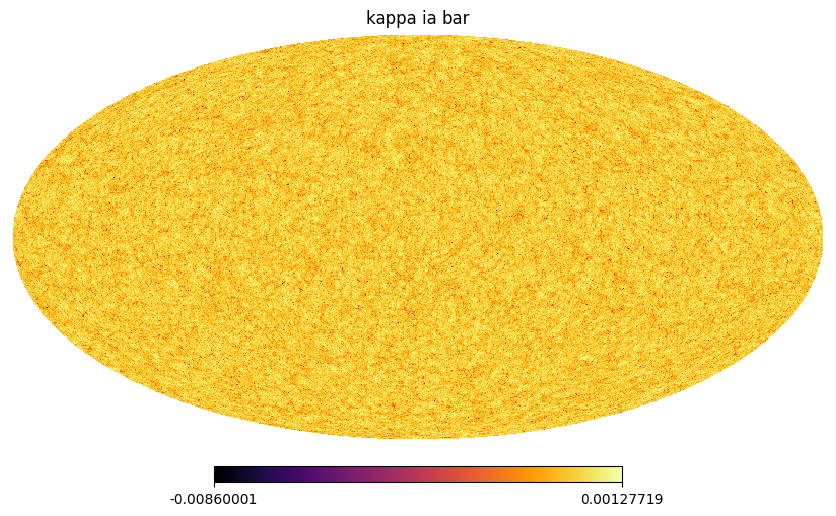

In [17]:
hp.mollview(kappa_ia_bar, title='kappa ia bar', cmap='inferno')
plt.show()

In [18]:
#Compare the power spectrum with the prediction from cosmoSIS

sim_ia_cls = hp.anafast(kappa_ia_bar, pol=True, lmax=lmax, use_pixel_weights=True)

path = '/home/guerrini/cosmosis-standard-library/ia_pred/shear_cl_ii/'

ell = np.loadtxt(path+'ell.txt')
cl_ii = np.loadtxt(path+'bin_1_1.txt')

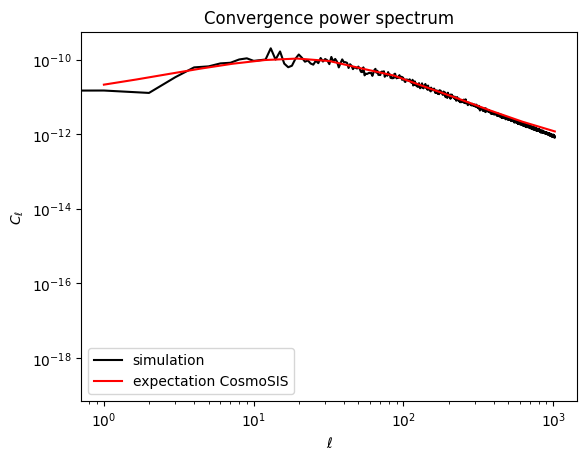

In [19]:
plt.figure()

#get the HEALPix pixel window function since the lensing fields have it
pw = hp.pixwin(nside, lmax=lmax)

l = np.arange(lmax+1)
plt.plot(l, sim_ia_cls, label="simulation", c='k')
plt.plot(ell, cl_ii, label="expectation CosmoSIS", c='r')


plt.xscale('log')
plt.yscale('log')

plt.legend()

plt.xlabel(r"$\ell$")
plt.ylabel(r"$C_\ell$")
plt.title("Convergence power spectrum")

plt.show()
#Looks good !


In [23]:
kappa_lensing = forward(path_sims, path_info, sim_number=1, nside=512, verbose=True)

[!] Preprocessing the Gower Street simulation 1...
[!] Reading the cosmological parameters...
[!] Done in 2.76 min.
[!] Extracting overdensity maps and redshift edges for the Gower Street simulation 1...


100it [02:57,  1.78s/it]


[!] Done in 2.97 min.
[!] Number of redshift shells: 77
[!] Larger redshift: 2.07237
[!] Performing the ray tracing using GLASS...


100%|██████████| 77/77 [00:01<00:00, 44.50it/s]


  0%|          | 0/77 [00:00<?, ?it/s]

100%|██████████| 77/77 [00:00<00:00, 126.23it/s]


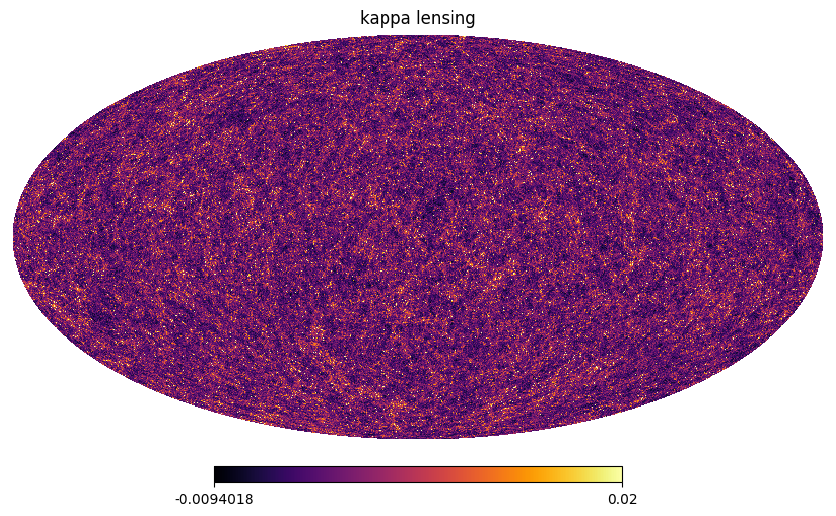

In [34]:
kappa_bar = weight_map_w_redshift(kappa_lensing, z_bin_edges, (dndz, z), verbose=True)

hp.mollview(kappa_bar, title='kappa lensing', cmap='inferno', max=0.02)
plt.show()

In [61]:
gamma = kappa2shear(kappa_lensing, lmax, verbose=True)

[!] Converting convergence map to shear maps with lmax=1024...


100%|██████████| 77/77 [01:49<00:00,  1.43s/it]


100%|██████████| 77/77 [00:00<00:00, 85.65it/s]


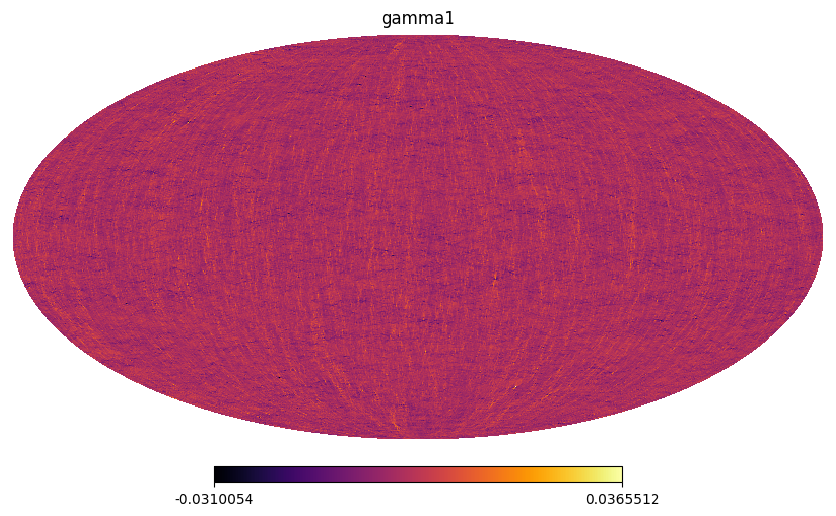

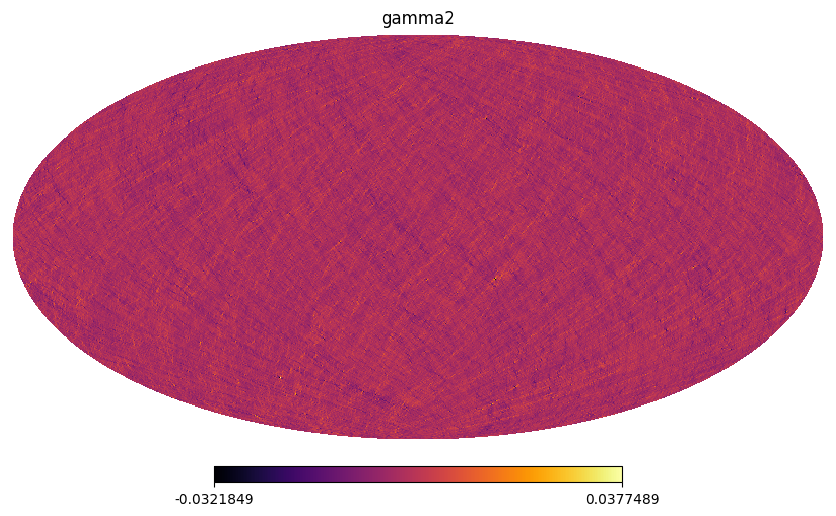

In [65]:
gamma_bar = weight_map_w_redshift(gamma, z_bin_edges, (dndz, z), verbose=True)

hp.mollview(gamma_bar.real, title='gamma1', cmap='inferno')
plt.show()
hp.mollview(gamma_bar.imag, title='gamma2', cmap='inferno')
plt.show()

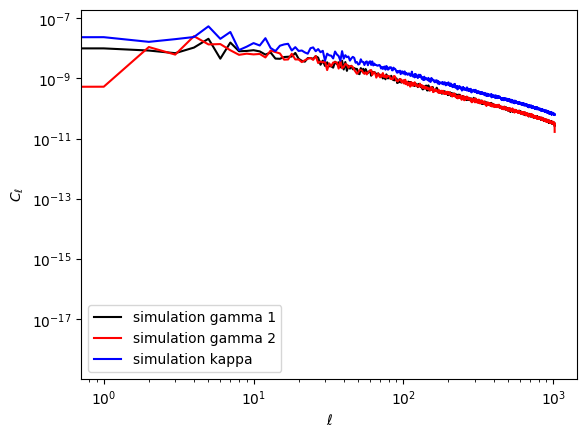

In [68]:
sim_gamma1_cls = hp.anafast(gamma_bar.real, pol=True, lmax=lmax, use_pixel_weights=True)
sim_gamma2_cls = hp.anafast(gamma_bar.imag, pol=True, lmax=lmax, use_pixel_weights=True)


plt.figure()

#get the HEALPix pixel window function since the lensing fields have it
pw = hp.pixwin(nside, lmax=lmax)

l = np.arange(lmax+1)
plt.plot(l, sim_gamma1_cls, label="simulation gamma 1", c='k')
plt.plot(l, sim_gamma2_cls, label="simulation gamma 2", c='r')
plt.plot(l, sim_cls, label="simulation kappa", c='b')

plt.xscale('log')
plt.yscale('log')

plt.legend()

plt.xlabel(r"$\ell$")
plt.ylabel(r"$C_\ell$")

plt.show()

### Apply UNIONS mask

In [36]:
path_mask = '/n17data/mkilbing/astro/data/CFIS/v1.0/Lensfit/masks/CFIS3500_THELI_mask_hp_4096.fits'

mask = hp.read_map(path_mask, verbose=True)
mask[mask>0] = 2
mask[mask==0] = 1
mask[mask==2] = 0
print(f"Area: {np.sum(mask)*hp.nside2pixarea(4096, degrees=True)} deg^2")
mask = downgrade_mask(mask, 2048, verbose=True, threshold=0.51)
print(f"Area: {np.sum(mask)*hp.nside2pixarea(2048, degrees=True)} deg^2")
mask = downgrade_mask(mask, 1024, verbose=True, threshold=0.51)
print(f"Area: {np.sum(mask)*hp.nside2pixarea(1024, degrees=True)} deg^2")
mask = downgrade_mask(mask, 512, verbose=True, threshold=0.51)
print(f"Area: {np.sum(mask)*hp.nside2pixarea(512, degrees=True)} deg^2")

/tmp/ipykernel_194424/2782961925.py:3: HealpyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
  mask = hp.read_map(path_mask, verbose=True)


Area: 2137.792178134421 deg^2
[!] Downgrading mask from nside=4096 to nside=2048...
[!] Done.
Area: 2137.087507517751 deg^2
[!] Downgrading mask from nside=2048 to nside=1024...
[!] Done.
Area: 2088.234716083018 deg^2
[!] Downgrading mask from nside=1024 to nside=512...
[!] Done.
Area: 1960.694866918937 deg^2


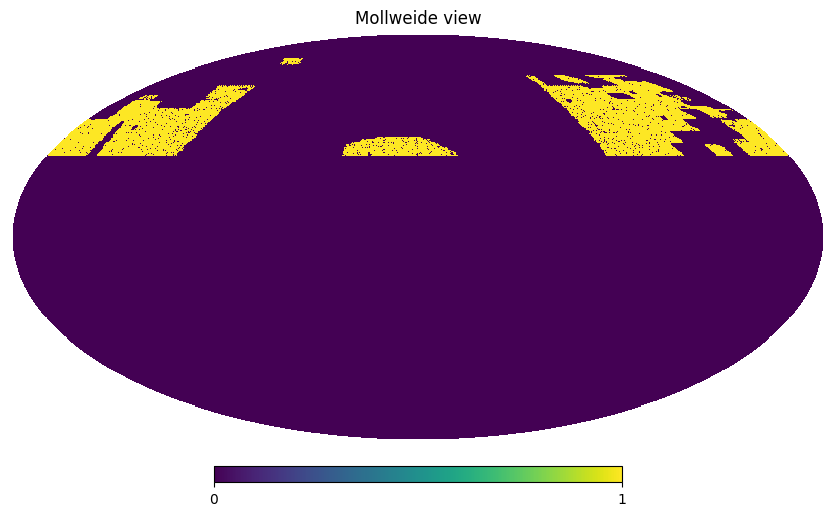

In [30]:
hp.mollview(mask)
plt.show()

In [28]:
np.sum(mask)*hp.nside2pixarea(1024, degrees=True)

2479.2111366285562